*Note: I found a small bug in pymc (with `TruncatedNormal`) while writing this notebook, so you will need to install the latest development version of the package in order for the examples to complete successfully. You can install the development version with `pip`*:

    pip install git+https://github.com/pymc-devs/pymc

In [1]:
import pathlib

import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import daft
from pyia import GaiaData
import arviz as az
import pymc as pm

# Hierarchical Models 2: Mixture Models

In the examples in the Hierarchical Models 1 notebook, our models have assumed that all of the objects we observe are true members of the population we want to model (e.g., star cluster, or all of the RV systems we had were binary star systems). We very rarely have this luxury: We typically have a complex superposition of multiple structures, or at least two components corresponding to an object of interest and the "field" or "background" population of objects. Another similar context in which a one-component population model would not be sufficient is when there are outliers in a dataset. For these contexts, the models we wrote down and explored in Hierarchical Models 1 are too simple to be useful for many real-world applications.

One way of handling datasets that contain objects from different populations or outliers is to use a *mixture model*. Because of how many problems have this structure, I personally think that mixture models are one of the most important tools to know as a data-oriented astronomer. Let's first talk about the fundamentals of mixture models and then explore an example of using a mixture model to measure the distance to a star cluster using Gaia data. 

## Gaussian Mixture Models

In the models we have looked at so far, any parameter or variable is either drawn from a single distribution (e.g., a single normal distribution in many cases) or is deterministically related to another variable (e.g., distance and parallax). However, this does not have to be the case: the underlying density distribution of a random variable could instead be a more complex thing, such as a mixture of multiple component distributions that each have their own parameters. 

A common and important example used in many statistics and machine learning applications is the *Gaussian Mixture Model* (GMM), in which the probability density $p(x | \boldsymbol{\theta})$ of some variable $x$ given parameters $\boldsymbol{\theta}$ is modeled as a sum of Gaussians each with a weight $w$. For example, for $K$ Gaussian mixture components, the GMM density is:

$$
p(x | \boldsymbol{\mu}, \boldsymbol{\sigma}) = 
    \sum_k^K w_k \, \mathcal{N}(x | \mu_k, \sigma_k^2)
$$

where $\sum_k^K w_k = 1$, and $\boldsymbol{\mu} = (\mu_1, \mu_2, ..., \mu_k)$, and again $\mathcal{N}(x \,|\, \mu, \sigma^2)$ represents a univariate normal distribution with mean $\mu$ and variance $\sigma^2$ (i.e. $\sigma$ is the standard deviation):

$$
\mathcal{N}(x \,|\, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi} \, \sigma} \, 
    \exp\left[-\frac{(x - \mu)^2}{2\,\sigma^2} \right]
$$

With the constraint on the sum of the weights, this GMM density still integrates to 1 and is therefore a valid probability density function, but now can have complex possibly multi-modal structure.

### Example: Fitting a line to data with Gaussian outliers

As a demonstration of using a Gaussian Mixture Model to handle outliers, we will return to the example case of fitting a straight line to data, but now we will assume that the data we have been given include outliers.

Let's first generate simulated data to work with:

In [125]:
rng = np.random.default_rng(seed=42)

N = 32
true_p = {'m': 3.17, 'b': -11.9}
true_x = np.sort(rng.uniform(0, 10, N))
true_y = true_p['m'] * true_x + true_p['b']

N_out = 8
out_idx = rng.choice(N, size=N_out)
true_y[out_idx] = rng.normal(0, 15, size=N_out)
y_err = rng.uniform(0.5, 3, N)

gmm_data = {
    'x': true_x,
    'y': rng.normal(true_y, y_err),
    'y_err': y_err
}

Because this is simulated data, we know which points are outliers — let's plot the data and use a different marker for the outliers to see:

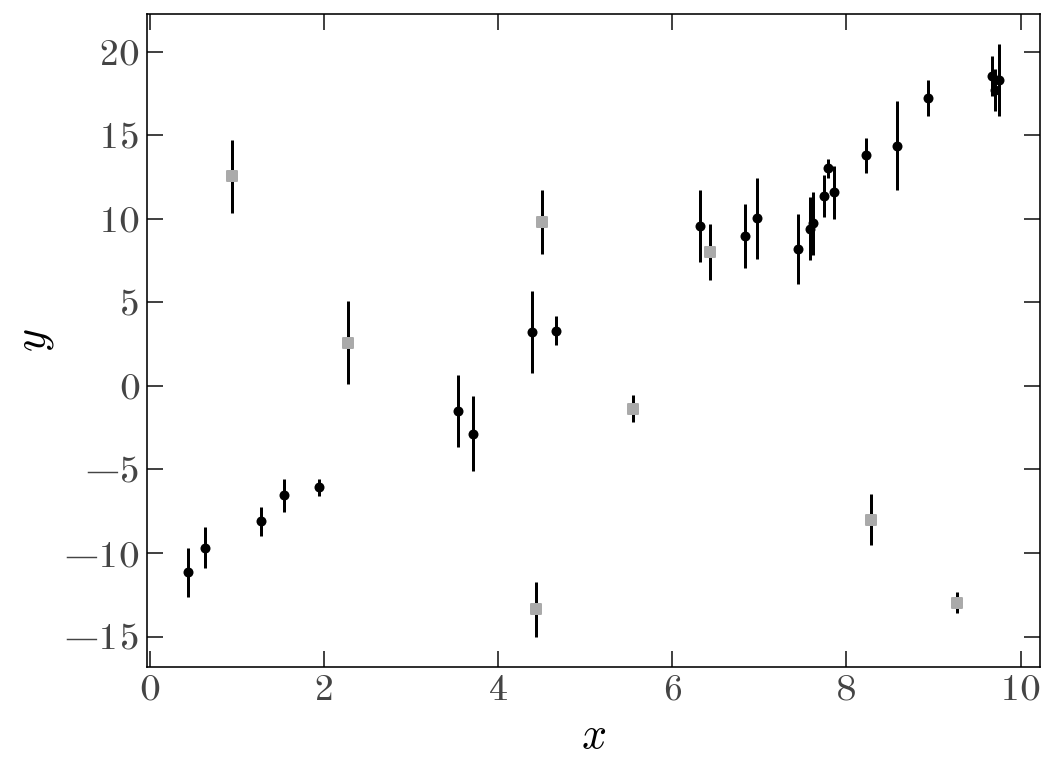

In [126]:
plt.figure(figsize=(8, 6))
plt.errorbar(
    gmm_data['x'], 
    gmm_data['y'], 
    gmm_data['y_err'],
    marker='o',
    ls='none'
)

plt.scatter(
    gmm_data['x'][out_idx], 
    gmm_data['y'][out_idx], 
    marker='s',
    facecolor='#aaaaaa',
    zorder=10,
)

plt.xlabel('$x$')
plt.ylabel('$y$');

As a demonstration of the impact of outliers or populations of objects that belong to a different class in the context of model fitting, let's do a linear least-squares regression to the data assuming now that we don't know a priori which points are outliers vs. not:

In [127]:
X = np.vander(gmm_data['x'], N=2)
Cinv = np.diag(1 / gmm_data['y_err']**2)
leastsq_m, leastsq_b = np.linalg.solve(
    X.T @ Cinv @ X, 
    X.T @ Cinv @ gmm_data['y']
)

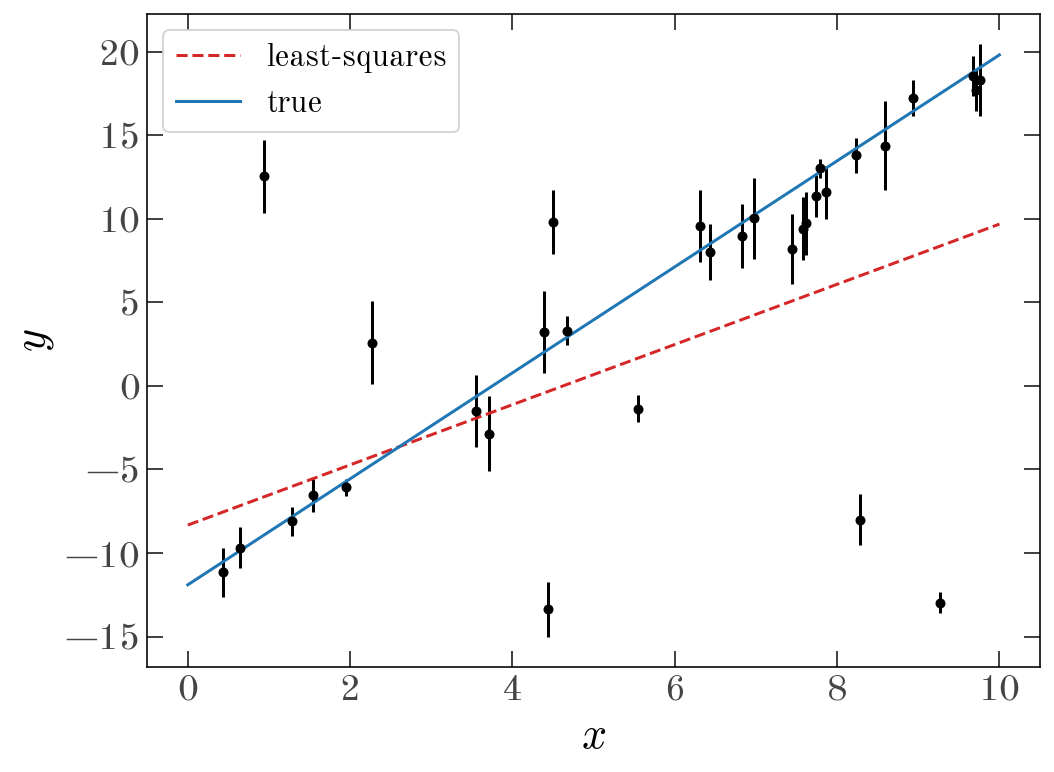

In [128]:
plt.figure(figsize=(8, 6))
plt.errorbar(
    gmm_data['x'], 
    gmm_data['y'], 
    gmm_data['y_err'],
    marker='o',
    ls='none'
)

xgrid = np.linspace(0, 10, 128)
plt.plot(xgrid, leastsq_m * xgrid + leastsq_b, marker='', color='tab:red', label='least-squares', linestyle='--')
plt.plot(xgrid, true_p['m'] * xgrid + true_p['b'], marker='', color='tab:blue', label='true')
plt.legend(fontsize=16)

plt.xlabel('$x$')
plt.ylabel('$y$');

The outliers have clearly biased our fit and led us to infer parameters for this linear model that are not consistent with the truth. Let's now construct a model to deal with these outlier data points. 

As mentioned above, we will use a *Gaussian Mixture Model* as a way of modeling the true density of objects, with one mixture component to represent the objects that follow the linear relation as we expect, and a second mixture component to represent the outliers. When constructing an outlier model, it sometimes helps to know about why these objects are outliers and to explicitly write down a generative model for the process that leads to these other data. This adds a little additional complexity to a model, but allows us to be more justified in our choice of outlier model and can lead to more precise inferences of the parameters you actually want to learn. Plus, as we saw, if you use MCMC methods to generate posterior samples over all of the parameters (inlier and outlier model components), you can use these samples to marginalize over the outlier model and obtain robust estimates of the inlier model. 

However, sometimes you don't know about the outliers, or you don't care and just need to get something working as a prototype. In these cases, using a broad Gaussian or other wide distribution to capture the outliers is often a good practical choice. That's the assumption we will work with her for our simulated data: We will assume the inlier data are generated from a straight line with Gaussian uncertainties, and the outlier distribution is a Gaussian centered on zero with an unknown variance. With mixture weights $\boldsymbol{w}=(w_1, w_2)$ such that $w_1 + w_2 = 1$, data $y$ and uncertainties $\sigma_y$, and outlier component standard deviation $\sigma_{\rm out}$, this model looks like:

$$
\begin{align}
\hat{y} &= m \, x + b\\
p(y \,|\, \hat{y}) &= \mathcal{N}(y \,|\, \hat{y}, \sigma_y^2) \\
p(\hat{y} \,|\, m, b) &= 
    w_1 \, \delta\left[\hat{y} - (m\,x + b)\right] +
    w_2 \, \mathcal{N}(\hat{y} \,|\, 0, \sigma_{\rm out}^2)
\end{align}
$$

where $\delta\left[\cdot\right]$ is the Dirac delta function.

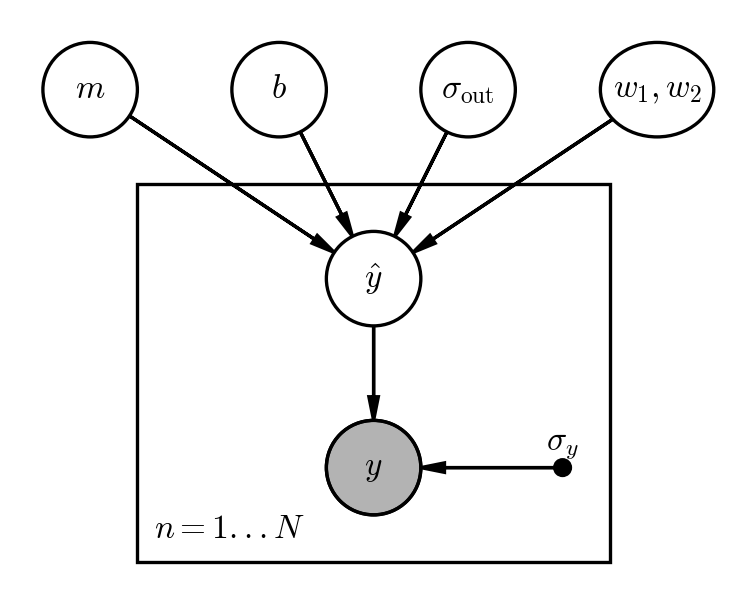

In [246]:
pgm = daft.PGM(dpi=120)

pgm.add_node("y", r"$y$", 0, 0, observed=True)
pgm.add_node("yhat", r"$\hat{y}$", 0, 1)
pgm.add_node("m", r"$m$", -1.5, 2)
pgm.add_node("b", r"$b$", -0.5, 2)
pgm.add_node("sigmao", r"$\sigma_{\rm out}$", 0.5, 2)
pgm.add_node("w", r"$w_1, w_2$", 1.5, 2, aspect=1.2)
pgm.add_node("sigmay", r"$\sigma_y$", 1, 0, fixed=True)

pgm.add_edge("yhat", "y")
pgm.add_edge("m", "yhat")
pgm.add_edge("b", "yhat")
pgm.add_edge("sigmao", "yhat")
pgm.add_edge("w", "yhat")
pgm.add_edge("sigmay", "y")

pgm.add_plate([-1.25, -0.5, 2.5, 2], label=r"$n = 1...N$", position="bottom left")

pgm.render();

At face value, this looks like the stellar distance model we explored in the previous notebook: We have some population-level parameters ($m, b, \sigma_{\rm out}, \boldsymbol{w}$), and many object-level parameters (the $\hat{y}$'s). Given the PGM above, our joint probability for the parameters can be factorized as:

$$
p(m, b, \sigma_{\rm out}, \boldsymbol{w}, \hat{\boldsymbol{y}}, \boldsymbol{y}) =
    p(\boldsymbol{y} \,| \, \hat{\boldsymbol{y}}) \, 
    p(\hat{\boldsymbol{y}} \,|\, m, b, \sigma_{\rm out}, \boldsymbol{w}) \,
    p(m) \, p(b) \, p(\sigma_{\rm out}) \, p(\boldsymbol{w})
$$

However, unlike the parallax/distance example, here because of the forms of the mixture model components above, it turns out that we can analytically marginalize out the per-object "true" $y$ parameters $\hat{y}$. The relevant integrals either contain a convolution of a Gaussian and a delta function, or two Gaussians, both of which have closed-form solutions:

$$
\begin{align}
p(m, b, \sigma_{\rm out}, w, \boldsymbol{y}) &= 
    \int \textrm{d} \hat{\boldsymbol{y}} \, 
        p(m, b, \sigma_{\rm out}, \boldsymbol{w}, \hat{\boldsymbol{y}}, \boldsymbol{y}) \\
    &= p(m) \, p(b) \, p(\sigma_{\rm out}) \, p(\boldsymbol{w}) \, 
        \int \textrm{d} \hat{\boldsymbol{y}} \,
            p(\boldsymbol{y} \,| \, \hat{\boldsymbol{y}}) \, 
            p(\hat{\boldsymbol{y}} \,|\, m, b, \sigma_{\rm out}, \boldsymbol{w}) \\
\int \textrm{d} \hat{y} \, 
    p(y \,| \, \hat{y}) \, 
    p(\hat{y} \,|\, m, b, \sigma_{\rm out}, \boldsymbol{w})
        &= w_1 \, \int \textrm{d} \hat{y} \,
            \mathcal{N}(y \,|\, \hat{y}, \sigma_y^2) \, \delta\left[\hat{y} - (m\,x + b)\right]
            + w_2 \, \int \textrm{d} \hat{y} \,
            \mathcal{N}(y \,|\, \hat{y}, \sigma_y^2) \, \mathcal{N}(\hat{y} \,|\, 0, \sigma_{\rm out}^2)\\
        &= w_1 \, \mathcal{N}(y \,|\, m\,x + b, \sigma_y^2) + 
            w_2 \, \mathcal{N}(y \,|\, 0, \sigma_y^2 + \sigma_{\rm out}^2)
\end{align}
$$

Let's implement this model with pymc:

In [151]:
with pm.Model() as model_line:
    # We will be lazy and use fairly simple prior pdfs for the slope and intercept of
    # the linear model:
    m = pm.Uniform('m', 0, 10, initval=3.)
    b = pm.Normal('b', 0, 25, initval=-13.)
    
    # For sigma_out, we will sample in log-sigma and use a linear prior on this 
    # transformed parameter, which is equivalent to a prior p(s) ~ 1/s:
    ln_s_out = pm.Uniform('ln_s_out', -3, 4, initval=np.log(10.))
    s2_out = pm.Deterministic('s_out', pm.math.exp(2 * ln_s_out))
    
    # The mixture weight w can be thought of as two parameters that represent the 
    # weights of each component in the mixture, but they must sum to one. Variables of
    # this form can be represented with a Dirichlet distribution:
    w = pm.Dirichlet('w', a=np.array([1, 1]))
    
    # For mixtures of Gaussian (Normal) distributions, pymc has a special helper class:
    pm.NormalMixture(
        'y',
        w=w,
        mu=pm.math.stack([
            m * gmm_data['x'] + b, 
            tt.zeros(len(gmm_data['x']))
        ]).T,
        sigma=pm.math.sqrt(
            pm.math.stack([
                gmm_data['y_err']**2, 
                gmm_data['y_err']**2 + s2_out
            ]).T
        ),
        observed=gmm_data['y']
    )
    
    # With all model components defined, we can now generate posterior samples:
    samples_line = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b, ln_s_out, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Let's look at statistics of the parameter chains:

In [152]:
az.summary(samples_line)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,-11.972,0.450,-12.790,-11.102,0.009,0.007,2317.0,2490.0,1.0
m,3.133,0.074,3.000,3.277,0.002,0.001,2260.0,2641.0,1.0
ln_s_out,2.324,0.273,1.872,2.884,0.005,0.004,3076.0,1672.0,1.0
w[0],0.734,0.083,0.579,0.880,0.001,0.001,3563.0,2467.0,1.0
w[1],0.266,0.083,0.120,0.421,0.001,0.001,3563.0,2467.0,1.0
s_out,122.846,85.047,28.998,260.782,2.196,1.762,3076.0,1672.0,1.0


Based on the convergence statistic (`r_hat` close to 1) and the ESS parameters (in the thousands), it looks like the sampling succeeded. Let's make a corner plot:

/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/pairplot.py:94: UserWarning: Argument reference_values does not include reference value for: w 0, s_out, w 1
  warnings.warn(


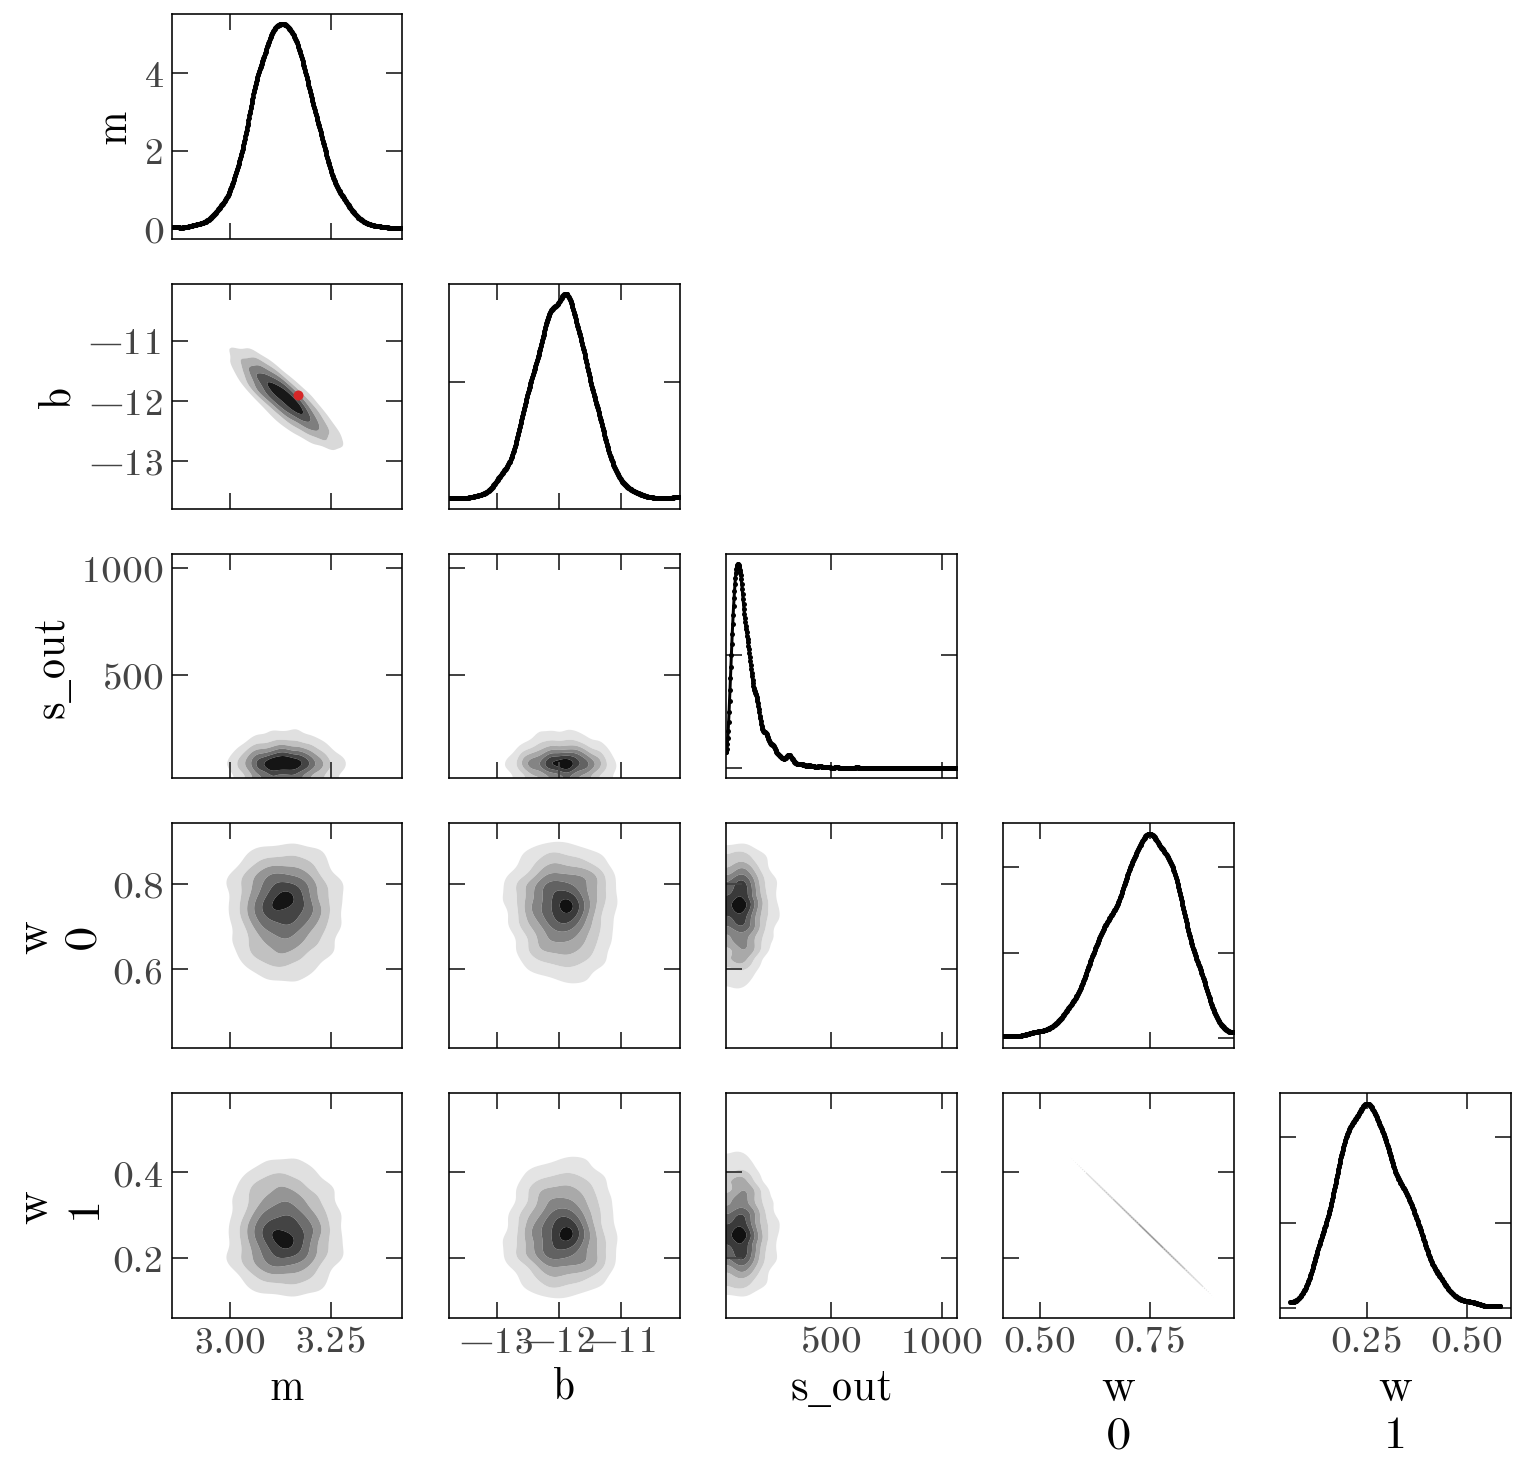

In [153]:
az.plot_pair(
    samples_line, 
    var_names=['m', 'b', 's_out', 'w'], 
    marginals=True,
    kind="kde",
    kde_kwargs=dict(contourf_kwargs=dict(cmap="Greys"), contour_kwargs=dict(alpha=0.0)),
    figsize=(12, 12),
    reference_values=true_p,
    reference_values_kwargs=dict(
        color="tab:red", markersize=5, label="true values", linestyle="none"
    )
);

We can also use the posterior samples to plot a credible region for our straight line model in the space of our data. First, we will extract a subset of the samples to use:

In [154]:
samples_line_subset = az.extract_dataset(samples_line, num_samples=1024, rng=rng)

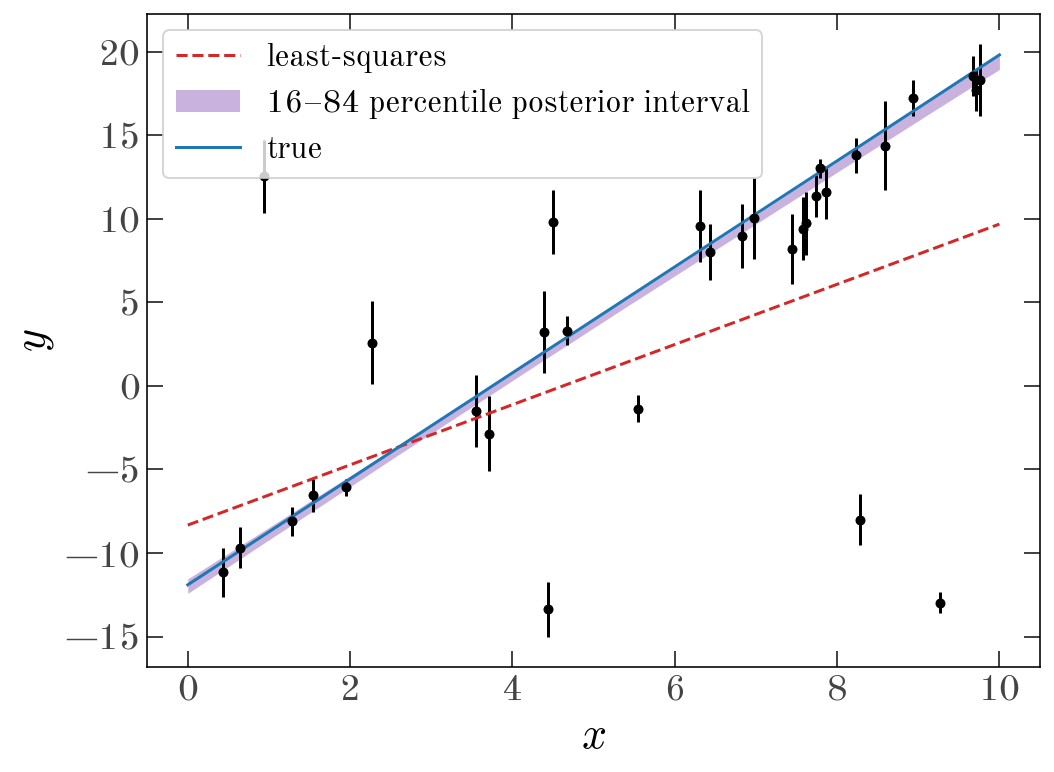

In [155]:
plt.figure(figsize=(8, 6))
plt.errorbar(
    gmm_data['x'], 
    gmm_data['y'], 
    gmm_data['y_err'],
    marker='o',
    ls='none'
)

xgrid = np.linspace(0, 10, 128)
plt.plot(xgrid, leastsq_m * xgrid + leastsq_b, marker='', color='tab:red', label='least-squares', linestyle='--')

model_tmp = samples_line_subset.m.values[None] * xgrid[:, None] + samples_line_subset.b.values[None]
plt.fill_between(xgrid, *np.percentile(model_tmp, [16, 84], axis=1), 
                 color='tab:purple', alpha=0.5, linewidth=0, label='16–84 percentile posterior interval')

plt.plot(xgrid, true_p['m'] * xgrid + true_p['b'], marker='', color='tab:blue', label='true')
plt.legend(fontsize=16)

plt.xlabel('$x$')
plt.ylabel('$y$');

Already our inference looks much more robust, and we recover parameters for the line model that are much more consistent with the truth. Awesome!

One other thing we can do with a model like this is to compute membership probabilities for each object in our sample — that is, we can compute estimates of the marginal posterior probability that a given object belongs in each of the classes in our model (here either the straight line component or the outlier population). 

If we define $q$ to be a discrete class label such that $q=0$ means a star belongs to the straight line mixture component, and $q=1$ means that a star is an outlier, we would like to get an estimate of $p(q=0 \,|\, \boldsymbol{y})$, i.e. the marginal posterior probability of being a straight line member, for each object. Defining $\boldsymbol{\theta} = (m, b, \sigma_{\rm out}, \boldsymbol{w})$ for brevity, the marginal posterior probability is equal to:

$$
p(q=0 \,|\, \boldsymbol{y}) = \int \textrm{d}\boldsymbol{\theta} \, 
    p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}) \,
    p(\boldsymbol{\theta} \,|\, \boldsymbol{y})
$$

On the right hand side, $p(\boldsymbol{\theta} \,|\, \boldsymbol{y})$ is the posterior pdf we generated samples from above — using the trick of Monte Carlo integration, we can therefore turn the integral in the expression above into a sum over posterior samples:

$$
p(q=0 \,|\, \boldsymbol{y}) \approx \sum_j p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}_j)
$$

where $\boldsymbol{\theta}_j$ is a sample from the posterior pdf (i.e. from the parameter chains generated above). But what is the pdf we need to evaluate inside the sum? Let's start by looking at and factorizing the joint probability both ways (i.e. the same way we got to Bayes' theorem):

$$
\begin{align}
p(q=0, \boldsymbol{y} \,|\, \boldsymbol{\theta}) &= 
    p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}) \, p(\boldsymbol{y} \,|\, \boldsymbol{\theta}) \\
    &= p(\boldsymbol{y} \,|\, q=0, \boldsymbol{\theta}) \, p(q=0)
\end{align}
$$

If we set these equal to another, we can see that:

$$
p(q=0 \,|\, \boldsymbol{y}, \boldsymbol{\theta}) = 
    \frac{p(\boldsymbol{y} \,|\, q=0, \boldsymbol{\theta}) \, p(q=0)}{p(\boldsymbol{y} \,|\, \boldsymbol{\theta})}
$$


$$
p(q=0) = w_1\\
p(q=1) = w_2\\
$$

Using the rules of discrete probabilities:

In [196]:
with pm.Model() as model_line2:
    # Same as above:
    m = pm.Uniform('m', 0, 10, initval=3.)
    b = pm.Normal('b', 0, 25, initval=-13.)
    
    # Same as above:
    ln_s_out = pm.Uniform('ln_s_out', -3, 4, initval=np.log(10.))
    s2_out = pm.Deterministic('s_out', pm.math.exp(2 * ln_s_out))
    
    # Same as above:
    w = pm.Dirichlet('w', a=np.array([1, 1]))
    
    # For mixtures of Gaussian (Normal) distributions, pymc has a special helper class:
    dist1 = pm.Normal.dist(m * gmm_data['x'] + b, gmm_data['y_err'])
    dist2 = pm.Normal.dist(0., pm.math.sqrt(gmm_data['y_err']**2 + s2_out))
    pm.Deterministic('logp1', pm.logp(dist1, gmm_data['y']))
    pm.Deterministic('logp2', pm.logp(dist2, gmm_data['y']))
    
    pm.Mixture(
        'y',
        w=w,
        comp_dists=[dist1, dist2],
        observed=gmm_data['y']
    )
    
    # With all model components defined, we can now generate posterior samples:
    samples_line2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b, ln_s_out, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8817, but should be close to 0.8. Try to increase the number of tuning steps.


In [199]:
from scipy.special import logsumexp

In [204]:
line2_logps = az.extract_dataset(samples_line2, var_names=['logp1', 'logp2'])

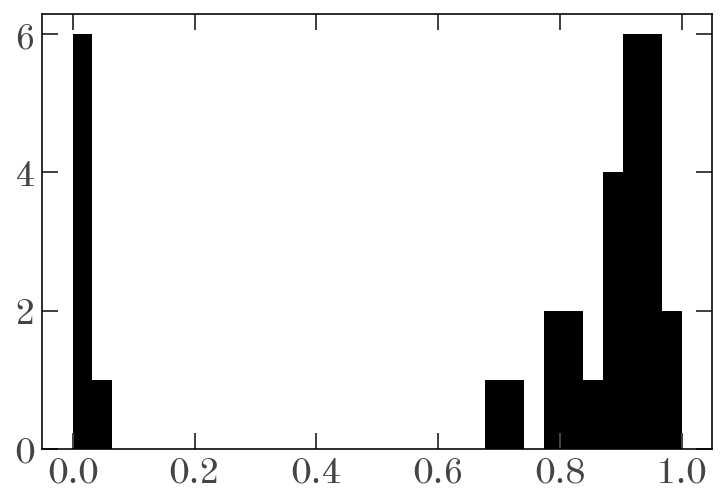

In [227]:
denom = np.logaddexp(
    line2_logps.logp1.values,
    line2_logps.logp2.values
)
membership_probs = np.exp(logsumexp(line2_logps.logp1.values - denom, axis=1)) / line2_logps.logp1.values.shape[1]

plt.hist(probs, bins=np.linspace(0, 1, 32));

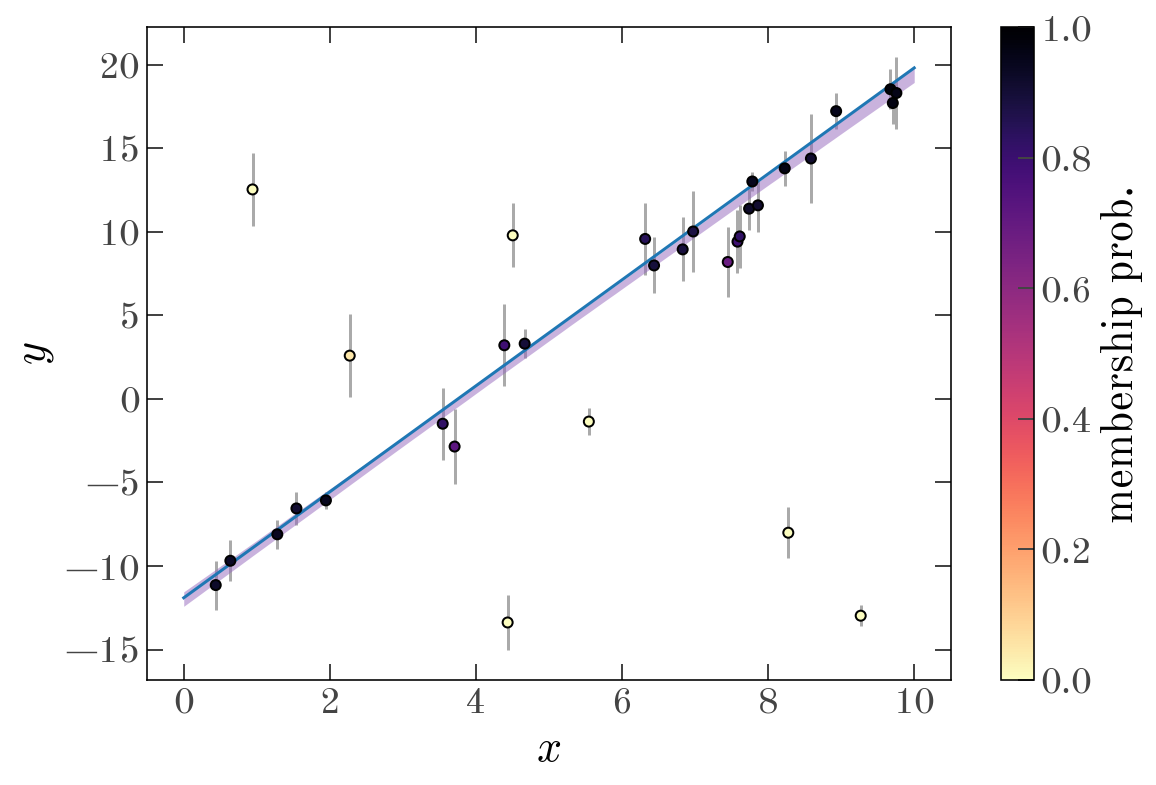

In [242]:
plt.figure(figsize=(9, 6))
plt.errorbar(
    gmm_data['x'], 
    gmm_data['y'], 
    gmm_data['y_err'],
    marker='',
    ls='none', 
    ecolor='#aaaaaa',
    zorder=1
)
cs = plt.scatter(
    gmm_data['x'], 
    gmm_data['y'], 
    c=membership_probs,
    zorder=10,
    cmap='magma_r',
    vmin=0,
    vmax=1,
    linewidth=1,
    edgecolor='k'
)
cb = plt.colorbar(cs)
cb.set_label('membership prob.')

model_tmp = samples_line_subset.m.values[None] * xgrid[:, None] + samples_line_subset.b.values[None]
plt.fill_between(xgrid, *np.percentile(model_tmp, [16, 84], axis=1), 
                 color='tab:purple', alpha=0.5, linewidth=0, label='16–84 percentile posterior interval')

plt.plot(xgrid, true_p['m'] * xgrid + true_p['b'], marker='', color='tab:blue', label='true')

plt.xlabel('$x$')
plt.ylabel('$y$');

## Mixture models in general

TODO:

Mixture models do not only have to contain Gaussians.

### Example: The mean distance of a star cluster and field stars

TODO: swap for NGC 6819

Mixture model using real data for NGC 6819. Discovered by Caroline Herschel

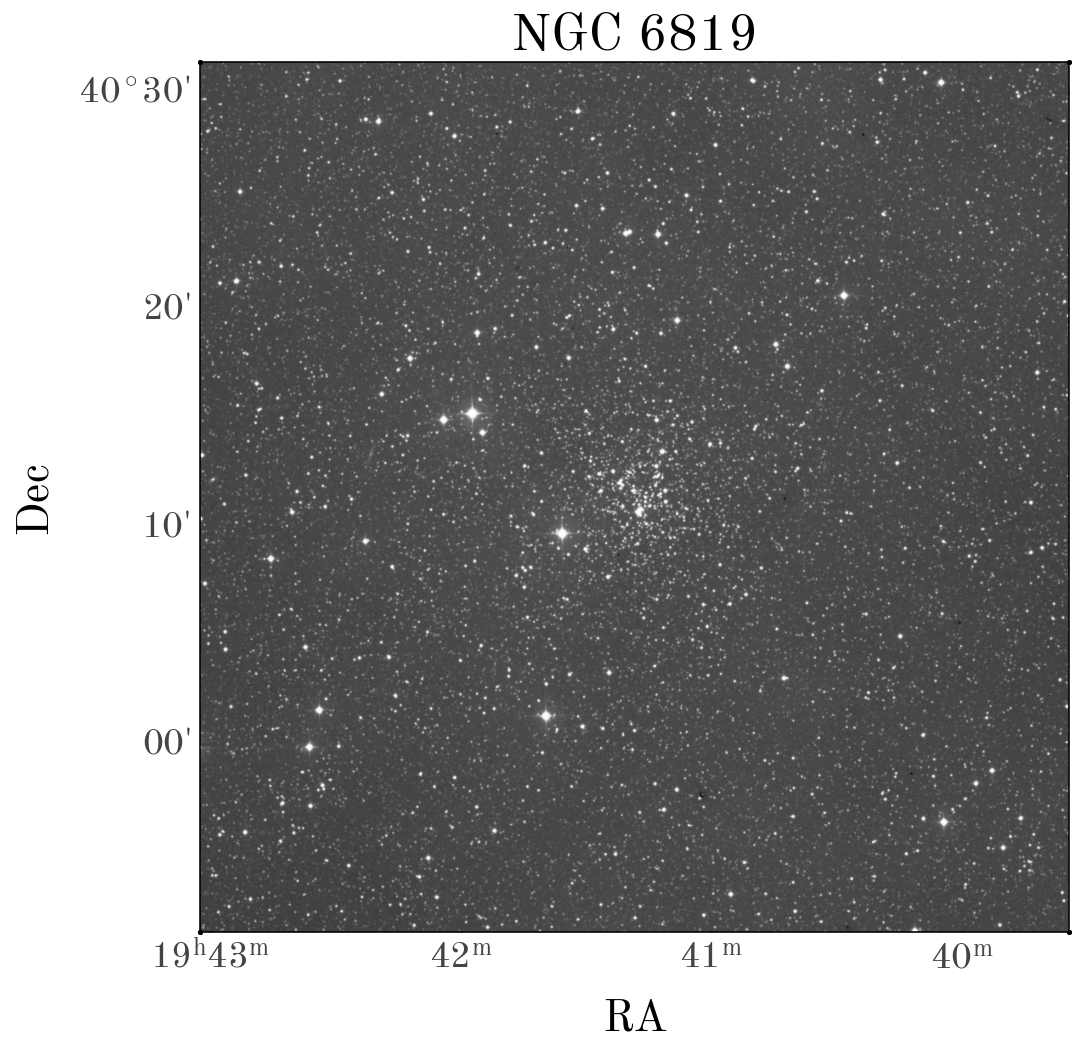

In [5]:
from astropy.io import fits
from astropy.wcs import WCS

hdul = fits.open("NGC6819-DSS-r.fits")
wcs = WCS(hdul[0].header)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=wcs))
ax.imshow(hdul[0].data, origin="lower", cmap="Greys_r")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.set_title("NGC 6819");

Load the Gaia data (see `Get-data.ipynb` notebook if you want to know how I queried and downloaded this data):

In [58]:
g = GaiaData("NGC6819-gaiadr3.fits.gz")
g = g[::10]

In [59]:
c = g.get_skycoord(distance=False)

In [165]:
init_r = 1 / g.parallax.to_value(u.mas)
init_r[init_r <= 0] = np.random.beta(2, 5, size=(init_r <= 0).sum()) * 2/0.2

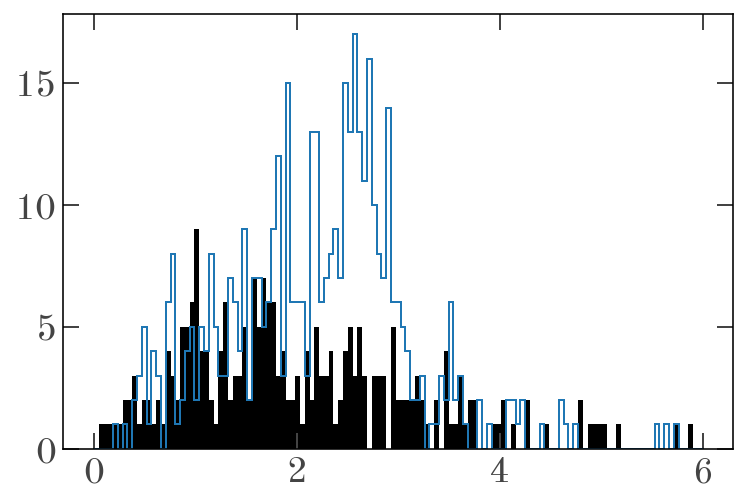

In [166]:
cluster_c = coord.SkyCoord.from_name("NGC 6819")
mask = c.separation(cluster_c) > (15 * u.arcmin)
# mask = c.separation(cluster_c) < (10*u.arcmin)

_bins = np.linspace(0, 6, 128)
plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 5) & mask],
    bins=_bins,
);

plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 5) & ~mask],
    bins=_bins,
    histtype='step'
);

# plt.hist(
#     g.parallax.to_value(u.mas)[(g.parallax_over_error > 5) & mask],
#     bins=np.linspace(0.1, 0.7, 128)
# );

/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_88448/3254036153.py:7: RuntimeWarning: divide by zero encountered in log
  return (2*np.log(r)) - 3*np.log(L) - np.log(2) - r/L


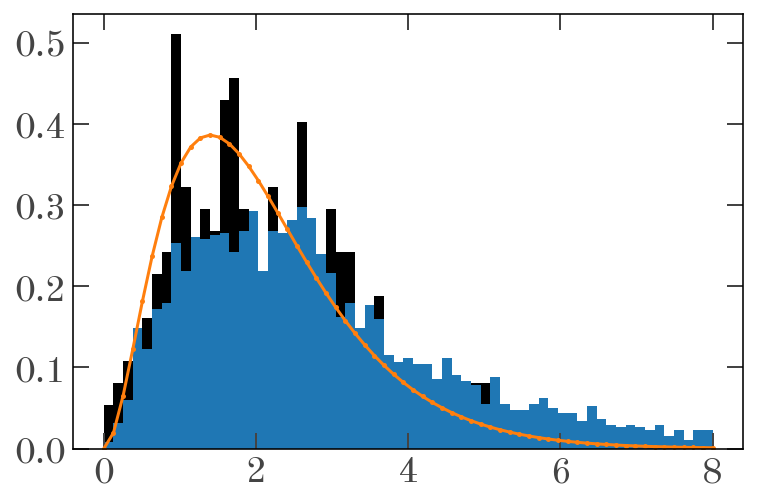

In [168]:
_bins = np.linspace(0, 8, 64)
plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 4) & mask],
    bins=_bins,
    density=True
)
plt.hist(
    init_r,
    bins=_bins,
    density=True
)
plt.plot(_bins, np.exp(exp_dec_space_density_np(_bins, 0.7)))

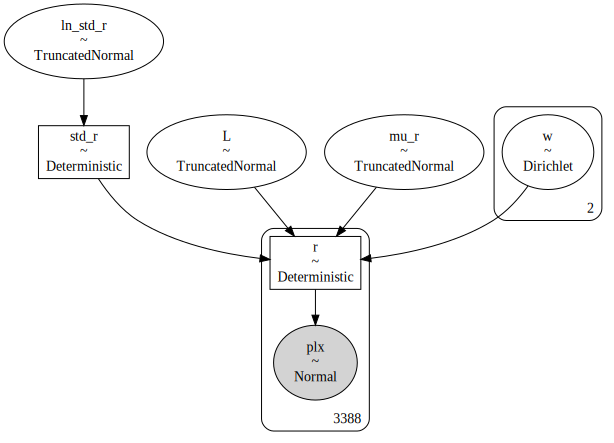

In [184]:
r_grid = np.linspace(1e-1, 10, 256)
with pm.Model() as cluster_model:
    # Prior set from literature values: https://en.wikipedia.org/wiki/NGC_6819
    mu_r = pm.TruncatedNormal("mu_r", mu=2.16, sigma=0.5, lower=0, initval=2.16)
    # ln_std_r = pm.Uniform("ln_std_r", -10, -1, initval=-6)
    ln_std_r = pm.TruncatedNormal("ln_std_r", -6, 5, lower=-10, upper=-1, initval=-6)
    std_r = pm.Deterministic("std_r", pm.math.exp(ln_std_r))

    # TODO:
    L = pm.TruncatedNormal("L", mu=1., sigma=2, lower=0, initval=1.)
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))
    dist1 = pm.TruncatedNormal.dist(mu_r, std_r, lower=0)
    # dist2 = pm.Bound.dist(pm.ChiSquared.dist(nu=6), lower=0)
    dist2 = pm.TruncatedNormal.dist(L, 1.5, lower=0)

    r = pm.Mixture(
        'r',
        w=w,
        comp_dists=[dist1, dist2],
        shape=len(g),
        initval=init_r
    )
    
    # mix_logp = pm.Deterministic('mix_logp', pm.logp(r, r_grid))
    
    pm.Normal(
        "plx",
        1 / r,
        observed=g.parallax.to_value(u.mas),
        sigma=g.parallax_error.to_value(u.mas),
        shape=len(g),
    )
    
pm.model_to_graphviz(cluster_model)

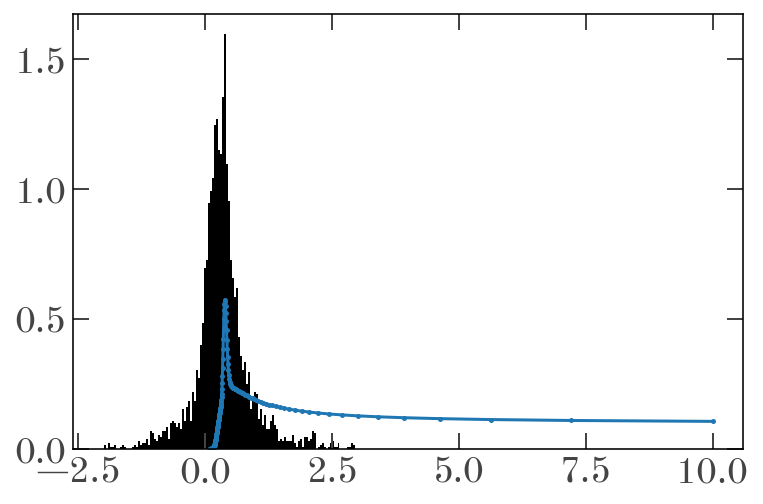

In [180]:
plx_bins = np.linspace(-2, 3, 128)
plt.hist(
    g.parallax.to_value(u.mas),
    bins=plx_bins,
    density=True
)

shit = cluster_model.compile_fn(mix_logp, inputs=[mu_r, ln_std_r, L, w])
plt.plot(1 / r_grid, np.exp(shit({'mu_r': 2.6, 'ln_std_r': -1.5, 'L': 2., 'w': [0.2, 0.8]})))

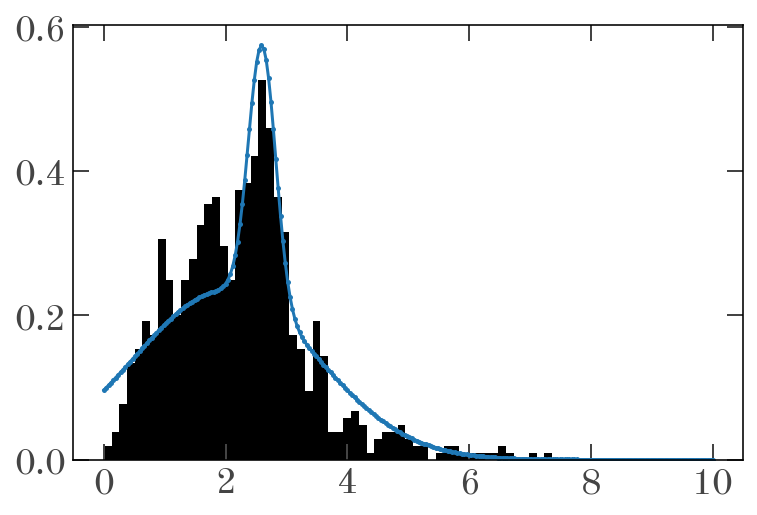

In [177]:
plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 4)],
    bins=_bins,
    density=True
)

shit = cluster_model.compile_fn(mix_logp, inputs=[mu_r, ln_std_r, L, w])
plt.plot(r_grid, np.exp(shit({'mu_r': 2.6, 'ln_std_r': -1.5, 'L': 2., 'w': [0.2, 0.8]})))

In [181]:
with cluster_model:
    opt = pm.find_MAP(start={'mu_r': 2.6, 'ln_std_r': -1.5, 'L': 2., 'w': [0.2, 0.8], 'r': init_r})

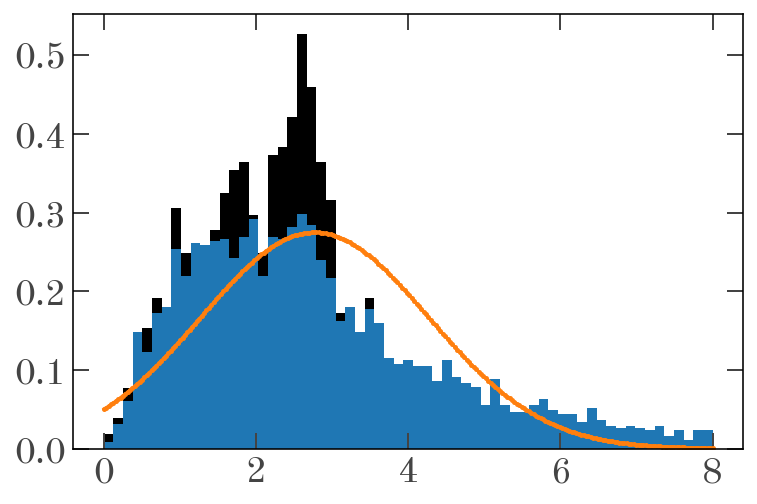

In [173]:
plt.hist(
    1 / g.parallax.to_value(u.mas)[(g.parallax_over_error > 4)],
    bins=_bins,
    density=True
)
plt.hist(init_r, bins=_bins, density=True)

plt.plot(grid, np.exp(opt['mix_logp']))

In [51]:
with cluster_model:
    samples = pm.sample(start=opt)

/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_88448/1685122262.py:2: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  opt = pm.sample(start=opt)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_r, ln_std_r, L, w, r]


/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19544 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target.

In [53]:
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_r,6.173,1.212,4.400,7.578,0.603,0.462,4.0,11.0,3.34
ln_std_r,-9.781,0.103,-9.889,-9.611,0.051,0.039,4.0,13.0,3.63
L,0.016,0.003,0.013,0.020,0.002,0.001,5.0,26.0,2.98
w[0],0.001,0.000,0.001,0.002,0.000,0.000,4.0,11.0,3.55
w[1],0.999,0.000,0.998,0.999,0.000,0.000,4.0,11.0,3.55
...,...,...,...,...,...,...,...,...,...
r[33869],4.191,1.559,1.673,5.609,0.777,0.595,4.0,14.0,3.26
r[33870],3.046,0.760,2.148,4.201,0.378,0.290,4.0,11.0,3.32
r[33871],3.191,0.180,2.966,3.481,0.089,0.068,5.0,12.0,3.10
r[33872],0.727,0.232,0.471,1.070,0.115,0.088,4.0,15.0,3.86


### Example: Cluster membership model with distance and proper motion

In [138]:
cluster_c = coord.SkyCoord.from_name("47 Tuc")
cluster_frame = coord.SkyOffsetFrame(origin=cluster_c)
c_cl = c.transform_to(cluster_frame)

In [143]:
other_mask = np.ones(len(g), dtype=bool)
for name in ["NGC 121", "ESO 28-19", "ESO 28-22", "Lindsay 14", "HW 5"]:
    other_c = coord.SkyCoord.from_name(name)
    other_mask &= c.separation(other_c) > 2 * u.arcmin

(-1.1, 1.1)

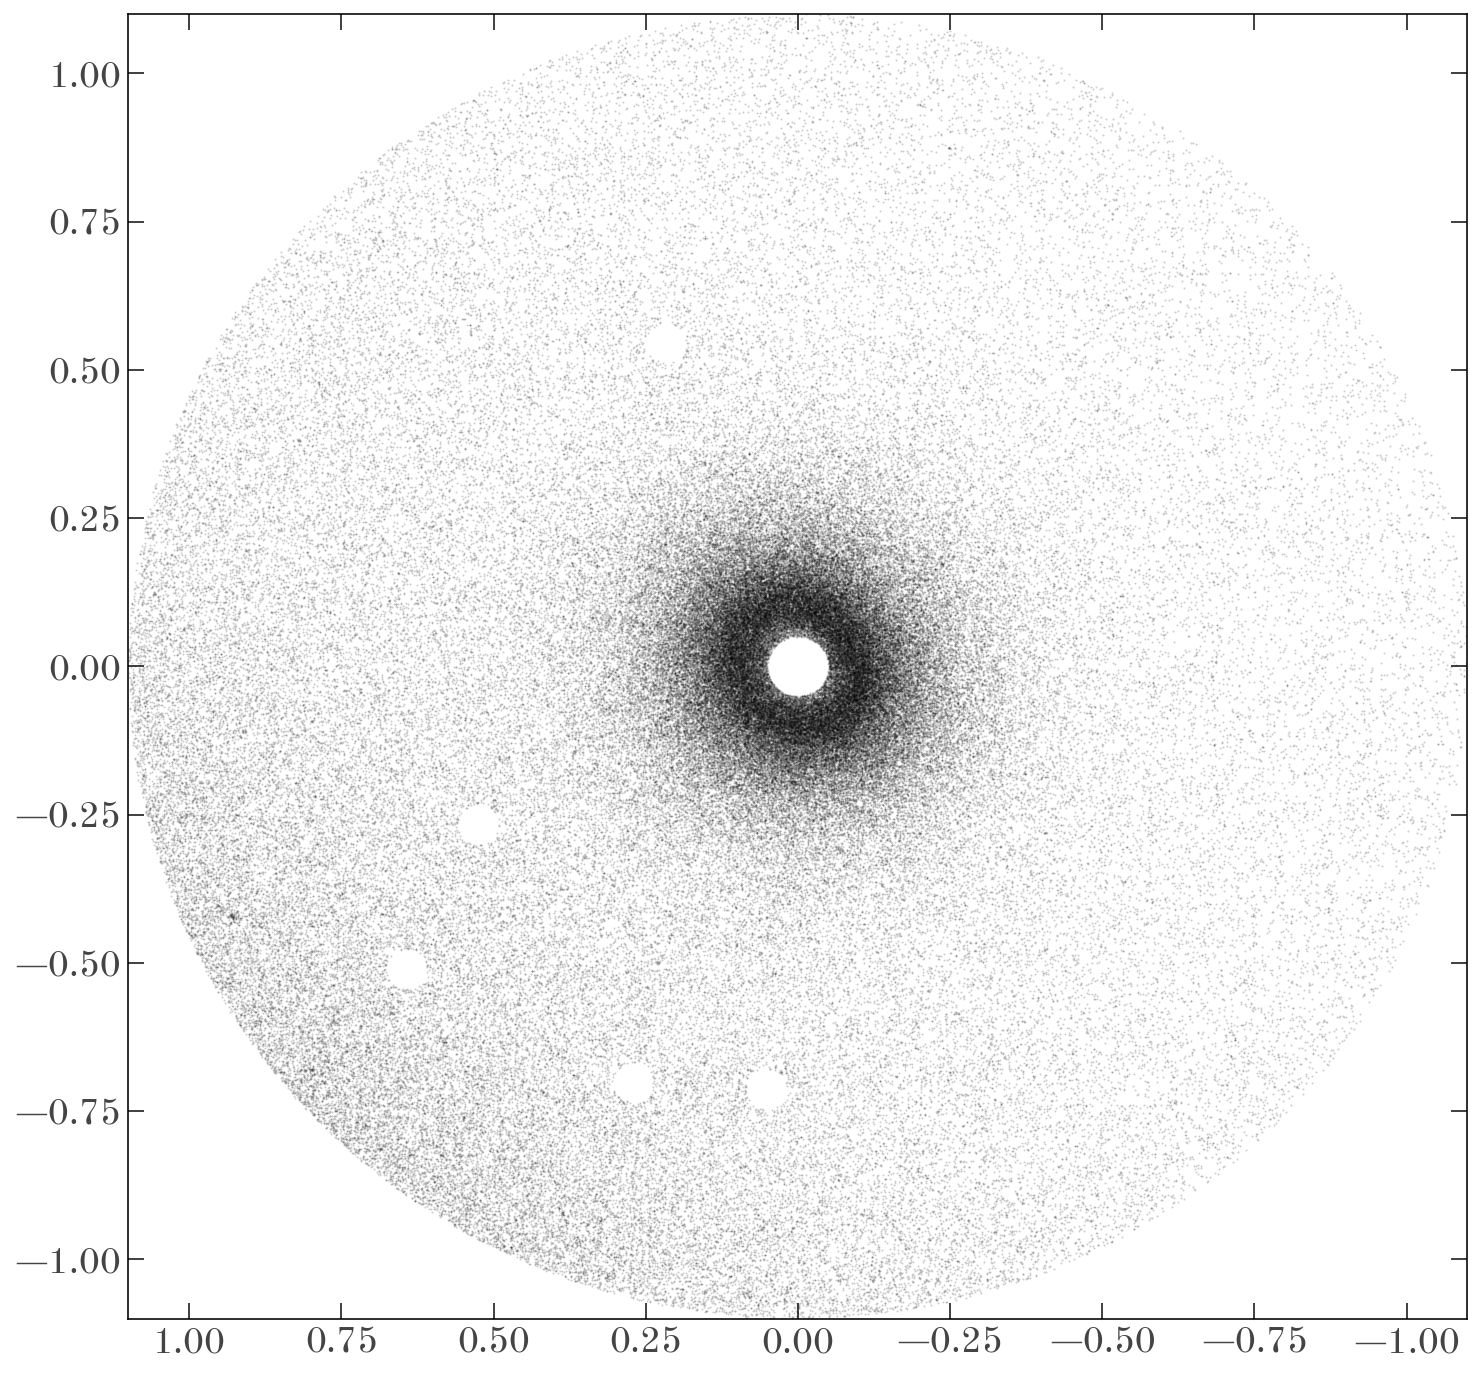

In [144]:
# fig, ax = plt.subplots(figsize=(6, 6))
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(
    c_cl.lon.degree[other_mask],
    c_cl.lat.degree[other_mask],
    marker="o",
    mew=0,
    ls="none",
    alpha=0.2,
    ms=1.0,
)
ax.set_xlim(1.1, -1.1)
ax.set_ylim(-1.1, 1.1)

In [146]:
cl_sky_mask = (
    (c.separation(cluster_c) < 0.25 * u.deg) & (c.separation(cluster_c) > 3 * u.arcmin)
) & other_mask
cl_area = np.pi * ((0.25 * u.deg) ** 2 - (3 * u.arcmin) ** 2)

no_cl_sky_mask = (
    (c.separation(cluster_c) > 1 * u.deg) & (c.separation(cluster_c) < 1.1 * u.deg)
) & other_mask
no_cl_area = np.pi * ((1.1 * u.deg) ** 2 - (1 * u.deg) ** 2)

cl_area, no_cl_area

(<Quantity 0.18849556 deg2>, <Quantity 0.65973446 deg2>)

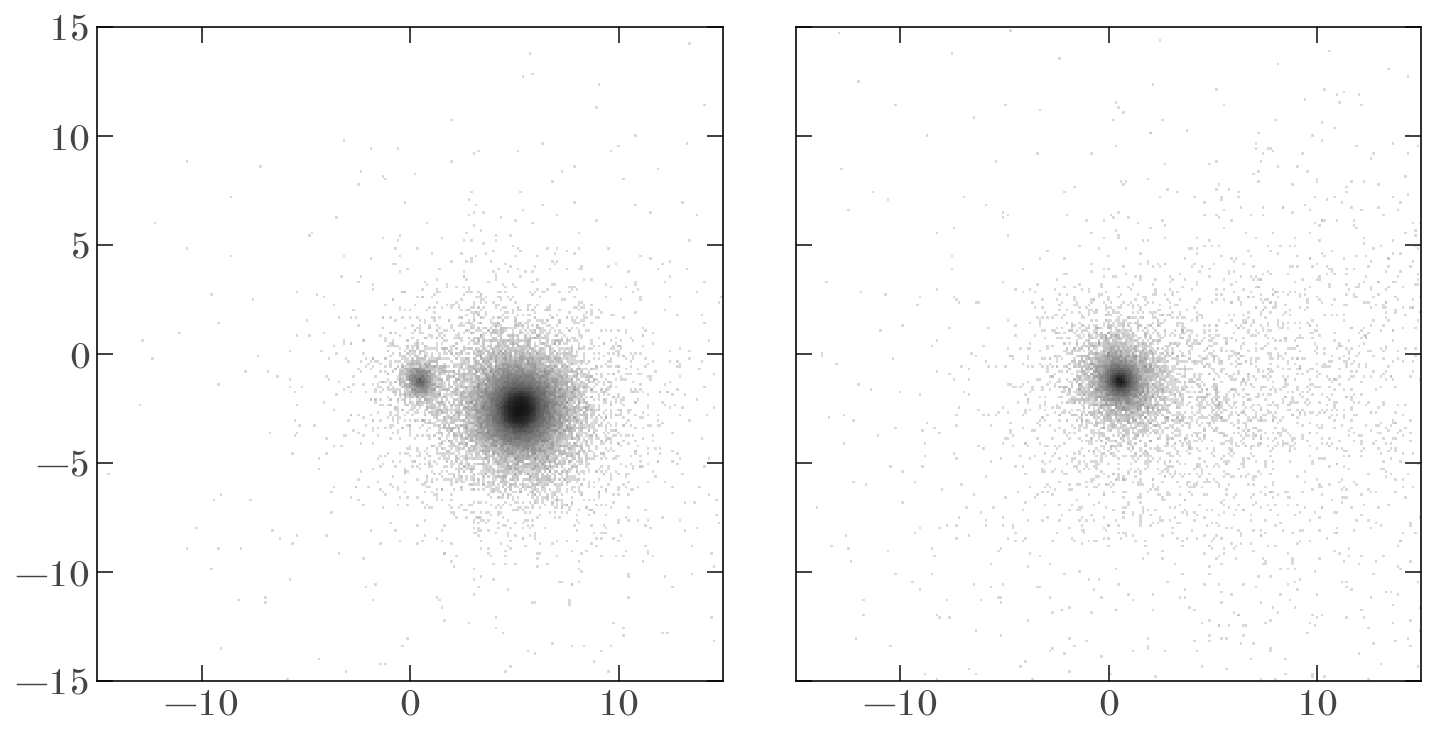

In [147]:
bins = np.linspace(-15, 15, 256)

fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)

ax = axes[0]
N = cl_sky_mask.sum()
ax.hist2d(
    c.pm_ra_cosdec.value[cl_sky_mask],
    c.pm_dec.value[cl_sky_mask],
    bins=bins,
    norm=mpl.colors.LogNorm(vmin=0.1, vmax=1e3),
    cmap="Greys",
)

ax = axes[1]
N = no_cl_sky_mask.sum()
ax.hist2d(
    c.pm_ra_cosdec.value[no_cl_sky_mask],
    c.pm_dec.value[no_cl_sky_mask],
    bins=bins,
    norm=mpl.colors.LogNorm(vmin=0.1, vmax=1e3),
    cmap="Greys",
);

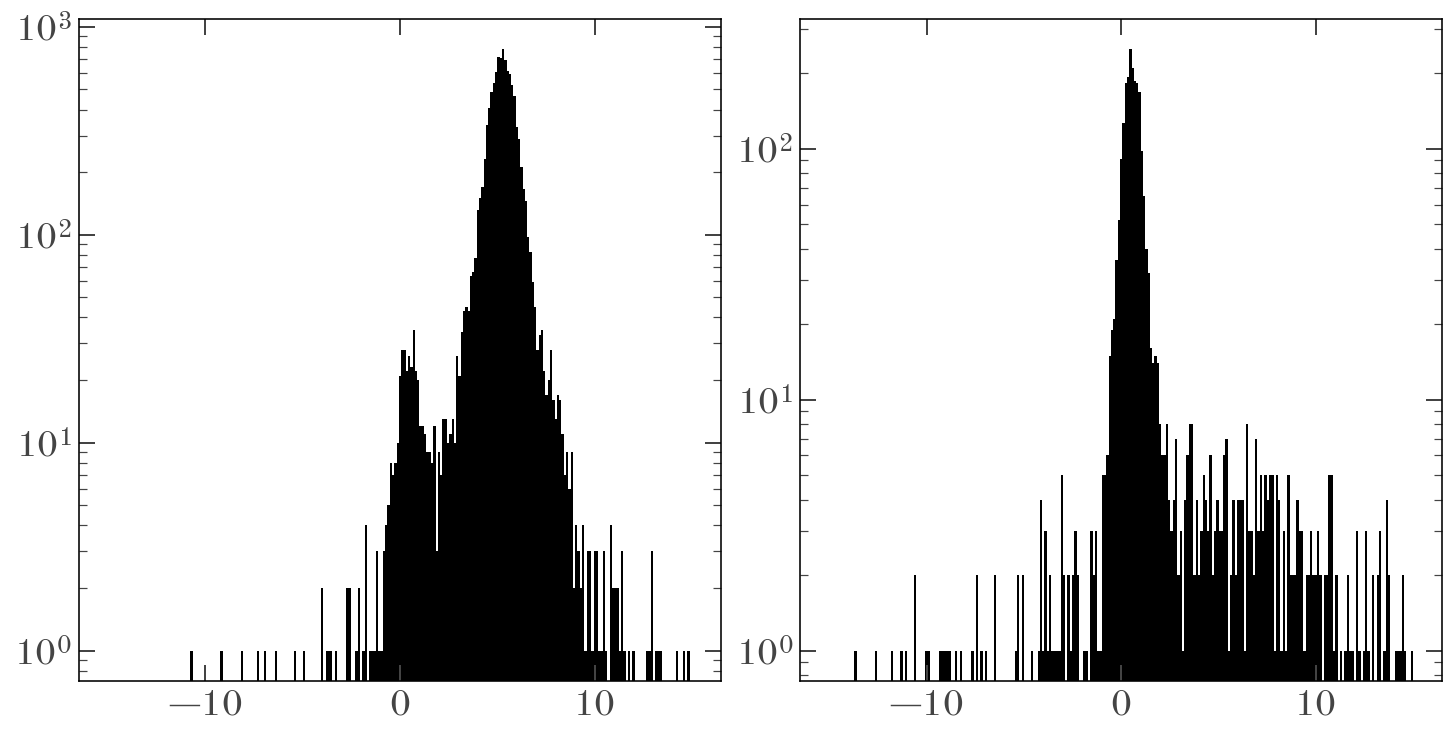

In [152]:
bins = np.linspace(-15, 15, 256)
# magmask = g.phot_g_mean_mag < 18.*u.mag
magmask = (g.phot_g_mean_mag > 19.5 * u.mag) & (g.phot_g_mean_mag < 20 * u.mag)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, constrained_layout=True)

ax = axes[0]
ax.hist(
    c.pm_ra_cosdec.value[cl_sky_mask & magmask],
    bins=bins,
)
ax.set_yscale("log")

ax = axes[1]
ax.hist(
    c.pm_ra_cosdec.value[no_cl_sky_mask & magmask],
    bins=bins,
)
ax.set_yscale("log")

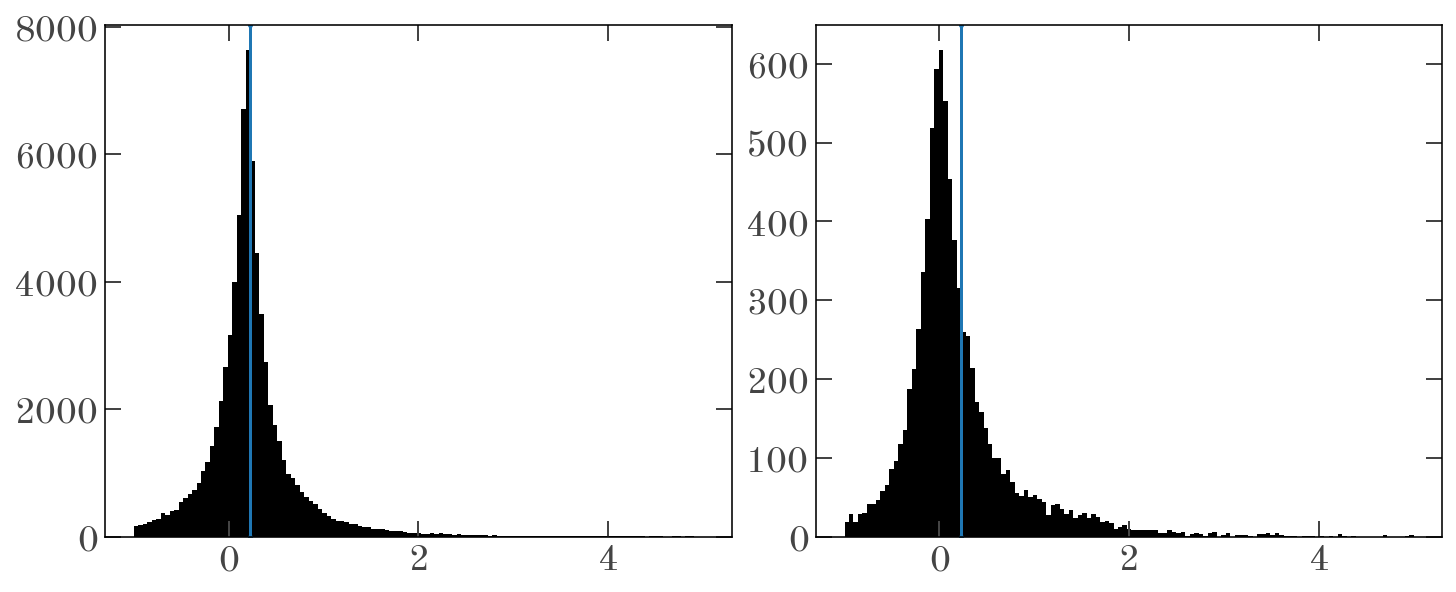

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, constrained_layout=True)

ax = axes[0]
ax.hist(
    g.parallax.value[cl_sky_mask],
    bins=np.linspace(-1, 5, 128),
)
ax.axvline(1 / 4.5, color="tab:blue")

ax = axes[1]
ax.hist(
    g.parallax.value[no_cl_sky_mask],
    bins=np.linspace(-1, 5, 128),
)
ax.axvline(1 / 4.5, color="tab:blue")

# ax.set_yscale('log')

## Recap and Other Resources

Other good resources on this topic are:
- [Dan F-M's Mixture Models tutorial](https://dfm.io/posts/mixture-models/)
- Dan's similar [outlier model implemented with numpyro](https://dfm.io/posts/intro-to-numpyro/)
